In [1]:
import pandas as pd
import cobra
import driven
import numpy as np
from driven.data_sets import ExpressionProfile
from pickle import load

In [2]:
fname = '../data/nobori_2018/pnas.1800529115.sd02.xlsx'
conditions = ['MM','vivo','flg22','D36E','AvrRpt2','AvrRps4']
all_conditions_frames = []
condition_to_p = {}
# load the up and down sheet for each comparison, then merge
# them into a single dataframe and rename the columns to meet the
# conventions in the driven package.
for condition in conditions:
    down = pd.read_excel(fname,sheet_name=condition+"_down")
    down = down.rename({condition+'_down':'gene'},axis='columns')
    up = pd.read_excel(fname,sheet_name=condition+"_up")
    up = up.rename({condition+'_up':'gene'},axis='columns')
    both = pd.concat([down,up])
    fchange_col = both.columns
    expression_column = [c for c in both.columns if "fold change" in c][0]
    p_column = [c for c in both.columns if "q-value" in c][0]
    condition = expression_column.split(': ')[1]
    
    both = both.rename({p_column:\
        "p-value-"+condition,expression_column:condition},axis='columns')
    
    # split each gene name by '-' to get the KEGG gene ID only,
    # then reassign it to the index
    new_index = [s[0] for s in both['gene'].str.split('-')]
    both.index = new_index
    both = both.drop('gene',axis=1)
    all_conditions_frames.append(both)
    
    # save the exact condition name and the p value column associated with it
    condition_to_p[condition] = "p-value-"+condition
xomics_data = pd.concat(all_conditions_frames,axis=1)

# for p-value columns that are NaN after the merge, reassign as 1 to indicate
# not significant
p_cols = [c for c in xomics_data.columns if "p-value" in c]
xomics_data[p_cols] = xomics_data[p_cols].fillna(value=1.0)

# for expression, do the equivalent (set foldchange to 0)
diff_cols = [c for c in xomics_data.columns if "p-value" not in c]
xomics_data[diff_cols] = xomics_data[diff_cols].fillna(value=0.0)

/Users/glm5uh/anaconda3/envs/driven_devel/lib/python3.7/site-packages/ipykernel_launcher.py:31 FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [3]:
# Load the count data
fname = "../data/nobori_2018/GSE103441_count.txt"
count_frame = pd.read_csv(fname,sep='\t',index_col=0)
# remove sample names from the end of column names
# and merge samples group-wise into a mean
#'_'.join(count_frame.columns[0].split('_')[:-1])
groups = set(['_'.join(c.split('_')[:-1]) for c in count_frame.columns])
mean_count_frame = pd.DataFrame(index=count_frame.index)
for group in groups:
    samps = [col for col in count_frame.columns if group in col]
    mean = count_frame[samps].mean(axis=1)
    mean_count_frame[group] = mean
mean_count_frame

,Pto_KB,Pto_sid2,Pto-AvrRpt2_b2b3,Pto-AvrRpt2_pad4,Pto_col_chitin,Pto_npr1,Pto-AvrRps4_KB,Pto-AvrRpt2_stp,Pto_sid2pmr4,Pto-AvrRpt2_pad4sid2,...,Pto_col_flg22,Pto-AvrRpt2_deps,Pto-AvrRpt2_KB,Pto_stp,Pto-AvrRpt2_npr1,Pto_de,Pto_col_mock,Pto-D36E_KB,Pto_MM_A80,Pto-AvrRpt2_de
PSPTOA0002,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.000000
PSPTOA0004,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.000000
PSPTOA0005,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.000000
PSPTOA0007,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.6,0.000000,0.00,0.000000
PSPTOA0008,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PSPTO_B0073-PilT domain-containing protein,219.0,273.0,383.5,268.142857,108.666667,269.5,3.5,238.0,388.0,320.000000,...,89.0,276.666667,130.000000,227.0,265.666667,291.50,207.2,0.333333,297.25,238.500000
PSPTO_B0074-hypothetical protein,137.0,131.4,157.5,128.714286,52.333333,144.5,0.0,91.5,161.0,140.000000,...,21.4,130.333333,69.000000,86.0,121.666667,165.00,60.4,0.000000,208.25,116.500000
"PSPTO_B0075-trbB protein, putative",21.0,15.0,12.5,19.285714,9.666667,14.0,0.0,11.5,9.5,22.333333,...,0.2,9.333333,10.333333,6.0,12.333333,10.75,15.2,0.000000,40.75,8.666667
PSPTO_B0076-trbC protein,27.5,17.2,16.5,11.142857,4.000000,12.5,0.0,25.5,17.5,7.333333,...,17.4,17.666667,15.666667,11.0,14.000000,20.25,25.6,0.000000,35.25,16.500000


In [4]:
# extract the groups of interest from count frame
flg_v_mock_counts = mean_count_frame[['Pto_col_mock','Pto_col_flg22']]
flg_v_mm_counts = mean_count_frame[["Pto_col_flg22", "Pto_MM_A80"]]
# replace A in the gene names with _ as in the other
# spreadsheets provided by the author
#the following line is not necessary because PSPTO_0001 and PSPTOA0001 are different genes, changed to 
#replace "A" with "_A" like plasmid B
flg_v_mock_counts.index = flg_v_mock_counts.index.str.replace('A','_A')
flg_v_mm_counts.index = flg_v_mm_counts.index.str.replace('A', "_A")
# add p-values
flg_v_mock_p = xomics_data["p-value-flg22_Pto - Mock_Pto"]
flg_v_mock_counts['p-value'] = flg_v_mock_p
flg_v_mock_counts = flg_v_mock_counts.fillna(1)

# rename the gene identifiers by splitting at "-" to only include the actual identifiers,
# not the descriptions.
identifiers = [gene.split('-')[0] for gene in flg_v_mock_counts.index.tolist()]

flg_v_mock_exp_prof = ExpressionProfile(identifiers=identifiers,
                                        conditions=['Pto_col_mock','Pto_col_flg22'],
                                        expression=flg_v_mock_counts[['Pto_col_mock','Pto_col_flg22']].values,
                                        p_values=np.reshape(flg_v_mock_counts['p-value'].values,(-1, 1)))




/Users/glm5uh/anaconda3/envs/driven_devel/lib/python3.7/site-packages/ipykernel_launcher.py:12 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
# load the medusa ensemble
import medusa
with open('../results/ensembles/pto_ensemble_100_essentiality.pickle', 'rb') as infile:
    ensemble = load(infile)

In [ ]:
# load the reconstruction
model = cobra.io.read_sbml_model('../results/reconstructions/pst7_complete_media.xml')

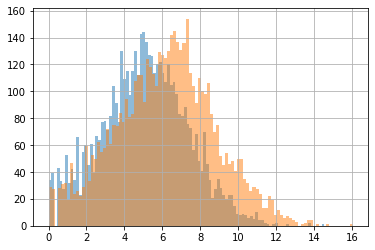

In [7]:
import numpy as np
np.log2(flg_v_mock_counts[flg_v_mock_counts['Pto_col_flg22'] >= 1]['Pto_col_flg22']
      ).hist(bins = 100, alpha = 0.5)
np.log2(flg_v_mock_counts[flg_v_mock_counts['Pto_col_mock'] >= 1]['Pto_col_mock']
      ).hist(bins = 100, alpha = 0.5)
# based on plot below, 4 (2 on log2 scale) seems like a reasonable cutoff that excludes the
# somewhat flat tail of the distribution from 0-2.

In [8]:
#apply gimme to all the ensemble members and save the solutions
mock_solutions = {}
flg_solutions = {}

member_count = 0
for member in ensemble.members:
    member_count += 1
    print(member_count)
    if member_count < 69: # no clue why GIMME hangs on this model. seems to get stuck at solver; kernel interrupt doesn't work
        ensemble.set_state(member)
        model, mock_solutions[member.id] = driven.gimme(ensemble.base_model,flg_v_mock_exp_prof,condition = 'Pto_col_mock',
                                                           cutoff=4,fraction_of_optimum=0.05)
        model, flg_solutions[member.id] = driven.gimme(ensemble.base_model,flg_v_mock_exp_prof,condition = 'Pto_col_flg22',
                                                           cutoff=4,fraction_of_optimum=0.05)

        

# mock_model, mock_solution = driven.gimme(model,flg_v_mock_exp_prof,condition = 'Pto_col_mock',
#                                                        cutoff=4,fraction_of_optimum=0.05)
# flg_model, flg_solution = driven.gimme(model,flg_v_mock_exp_prof,condition = 'Pto_col_flg22',
#                                                        cutoff=4,fraction_of_optimum=0.05)
#open up all the exchange reactions, but gimme does not have OF of biomass,
#look into the gimme solution more, figure out how the driven model is modified and what is supposed to return
#gunna take some inkering, model that is further constrained than hte original by wither loss of reaction
#or changing the bounds

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [ ]:
# see if we can get solutions for the rest here
for member in ensemble.members:
    member_count += 1
    print(member_count)
    ensemble.set_state(member)
    model, mock_solutions[member.id] = driven.gimme(ensemble.base_model,flg_v_mock_exp_prof,condition = 'Pto_col_mock',
                                                       cutoff=4,fraction_of_optimum=0.05)
    model, flg_solutions[member.id] = driven.gimme(ensemble.base_model,flg_v_mock_exp_prof,condition = 'Pto_col_flg22',
                                                       cutoff=4,fraction_of_optimum=0.05)

In [ ]:
# flg_reactions = []
# for reaction in flg_solution.fluxes.keys():
#     if abs(flg_solution.fluxes[reaction]) > 0:
#         flg_reactions.append(reaction)

# print(len(flg_reactions))

# mock_reactions = []
# for reaction in mock_solution.fluxes.keys():
#     if abs(mock_solution.fluxes[reaction]) > 0:
#         mock_reactions.append(reaction)

# print(len(mock_reactions))

In [10]:
# for each gimme solution, get the list of open reactions.
def get_open_reactions(gimme_solution):
    open_reactions = []
    for reaction in gimme_solution.fluxes.keys():
        if abs(gimme_solution.fluxes[reaction]) > 0:
            open_reactions.append(reaction)
    return open_reactions

mock_open_reactions = {}
flg_open_reactions = {}
for member_id in mock_solutions.keys():
    mock_open_reactions[member_id] = get_open_reactions(mock_solutions[member_id])
    flg_open_reactions[member_id] = get_open_reactions(flg_solutions[member_id])

In [15]:
mock_open_counts = {}
flg_open_counts = {}
for member_id in mock_open_reactions.keys():
    mock_open_counts[member_id] = len(mock_open_reactions[member_id])
    flg_open_counts[member_id] = len(flg_open_reactions[member_id])

In [30]:
members_mock = list(mock_open_counts.keys())
mock_counts_list = [mock_open_counts[member] for member in mock_open_counts.keys()]
mock_counts_df = pd.DataFrame(mock_counts_list, index = members_mock)
mock_counts_df.columns = ['mock']
members_flg = list(flg_open_counts.keys())
flg_counts_list = [flg_open_counts[member] for member in flg_open_counts.keys()]
flg_counts_df = pd.DataFrame(flg_counts_list, index = members_flg)
flg_counts_df.columns = ['flg']

In [36]:
all_open_rxn_counts_df = mock_counts_df.merge(flg_counts_df, left_index=True, right_index=True)

In [39]:
all_open_rxn_counts_df

,mock,flg
PST_gapfilled_0,485,485
PST_gapfilled_1,460,460
PST_gapfilled_2,486,482
PST_gapfilled_3,467,468
PST_gapfilled_4,472,461
...,...,...
PST_gapfilled_63,477,486
PST_gapfilled_64,478,472
PST_gapfilled_65,489,497
PST_gapfilled_66,478,480


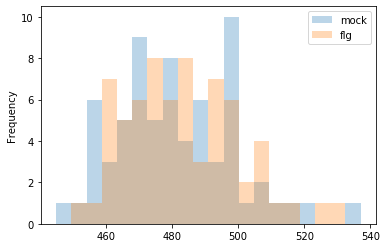

In [44]:
# not a crazy difference in density of open reaction counts.
all_open_rxn_counts_df.plot.hist(bins=20, alpha = 0.3)

In [45]:
# using the list of open reactions, iteratively set the state for the member, close reactions missing from the open list, and perform gene essentiality
mock_essentiality = {}
print('Performing essentiality simulations for mock')
for member_id in mock_open_reactions.keys():
    print(member_id)
    ensemble.set_state(member_id)
    with ensemble.base_model as model:
        for reaction in model.reactions:
            if reaction not in mock_open_reactions[member_id]:
                reaction.bounds = (0,0)
        mock_essentiality[member_id] = cobra.flux_analysis.single_gene_deletion(model, gene_list = model.genes)
        
flg_essentiality = {}
print('Performing essentiality simulations for flg')
for member_id in flg_open_reactions.keys():
    ensemble.set_state(member_id)
    print(member_id)
    with ensemble.base_model as model:
        for reaction in model.reactions:
            if reaction not in flg_open_reactions[member_id]:
                reaction.bounds = (0,0)
        flg_essentiality[member_id] = cobra.flux_analysis.single_gene_deletion(model, gene_list = model.genes)

Performing essentiality simulations for mock
PST_gapfilled_0
PST_gapfilled_1
PST_gapfilled_2
PST_gapfilled_3
PST_gapfilled_4
PST_gapfilled_5
PST_gapfilled_6
PST_gapfilled_7
PST_gapfilled_8
PST_gapfilled_9
PST_gapfilled_10
PST_gapfilled_11
PST_gapfilled_12
PST_gapfilled_13
PST_gapfilled_14
PST_gapfilled_15
PST_gapfilled_16
PST_gapfilled_17
PST_gapfilled_18
PST_gapfilled_19
PST_gapfilled_20
PST_gapfilled_21
PST_gapfilled_22
PST_gapfilled_23
PST_gapfilled_24
PST_gapfilled_25
PST_gapfilled_26
PST_gapfilled_27
PST_gapfilled_28
PST_gapfilled_29
PST_gapfilled_30
PST_gapfilled_31
PST_gapfilled_32
PST_gapfilled_33
PST_gapfilled_34
PST_gapfilled_35
PST_gapfilled_36
PST_gapfilled_37
PST_gapfilled_38
PST_gapfilled_39
PST_gapfilled_40
PST_gapfilled_41
PST_gapfilled_42
PST_gapfilled_43
PST_gapfilled_44
PST_gapfilled_45
PST_gapfilled_46
PST_gapfilled_47
PST_gapfilled_48
PST_gapfilled_49
PST_gapfilled_50
PST_gapfilled_51
PST_gapfilled_52
PST_gapfilled_53
PST_gapfilled_54
PST_gapfilled_55
PST_gapfilled

In [57]:
# threshold and merge the essentiality results into a dataframe
flg_essentiality_df = {}
mock_essentiality_df = {}
for member in mock_essentiality.keys():
    mock_essentiality_df[member] = mock_essentiality[member]['growth'] > 1E-6
    flg_essentiality_df[member] = flg_essentiality[member]['growth'] > 1E-6

members_mock = list(mock_essentiality.keys())
mock_essentiality_list = [mock_essentiality_df[member] for member in mock_essentiality_df.keys()]
mock_essentiality_df = pd.DataFrame(mock_essentiality_list, index = members_mock)
mock_essentiality_df.index = mock_essentiality_df.index + '_mock'
members_flg = list(flg_essentiality.keys())
flg_essentiality_list = [flg_essentiality_df[member] for member in flg_essentiality_df.keys()]
flg_essentiality_df = pd.DataFrame(flg_essentiality_list, index = members_flg)
flg_essentiality_df.index = flg_essentiality_df.index + '_flg'

all_essentiality_df = pd.concat([mock_essentiality_df,flg_essentiality_df], sort=True)

In [58]:
all_essentiality_df

,(PSPTO_3705),(PSPTO_4919),(PSPTO_5321),(PSPTO_1993),(PSPTO_3830),(PSPTO_3027),(PSPTO_2488),(PSPTO_5401),(PSPTO_1669),(PSPTO_4290),...,(PSPTO_1131),(PSPTO_0461),(PSPTO_0984),(PSPTO_1552),(PSPTO_5261),(PSPTO_2595),(PSPTO_4502),(PSPTO_3461),(PSPTO_3280),(PSPTO_5278)
PST_gapfilled_0_mock,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PST_gapfilled_1_mock,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PST_gapfilled_2_mock,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PST_gapfilled_3_mock,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PST_gapfilled_4_mock,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PST_gapfilled_63_flg,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PST_gapfilled_64_flg,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PST_gapfilled_65_flg,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PST_gapfilled_66_flg,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# # Perform genome-wide single gene essentiality simulations
# mock_gene_essentiality = cobra.flux_analysis.single_gene_deletion(mock_after_gimme,
#                                          gene_list = mock_after_gimme.genes)
# flg_gene_essentiality = cobra.flux_analysis.single_gene_deletion(flg_after_gimme,
#                                          gene_list = flg_after_gimme.genes)

In [ ]:
# # filter to binary growth/no growth (True/False, respectively)
# mock_gene_essentiality['growth'] = mock_gene_essentiality['growth'] > 1E-6
# flg_gene_essentiality['growth'] = flg_gene_essentiality['growth'] > 1E-6

In [ ]:
# # get discordant predictions
# discordant_mock = mock_gene_essentiality[mock_gene_essentiality['growth'].values != 
#                                          flg_gene_essentiality['growth'].values]
# discordant_flg = flg_gene_essentiality[flg_gene_essentiality['growth'].values != 
#                                          mock_gene_essentiality['growth'].values]

In [ ]:
# # save the constrained models
# cobra.io.write_sbml_model(mock_after_gimme, 
#                           '../results/reconstructions/gimme_constrained/mock_gimme_cutoff4.xml')
# cobra.io.write_sbml_model(flg_after_gimme, 
#                           '../results/reconstructions/gimme_constrained/flg_gimme_cutoff4.xml')